In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import pickle, gzip

import torch
from torch import nn
from torch.nn import functional as F

from sklearn.metrics import confusion_matrix
import itertools

In [2]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

# 1. Load Testing data

In [3]:
def GBdataLoad(data_dir, phase = 'test'):
    for i in os.listdir(data_dir):
        if 'good' in i and phase in i:
            G_train_X = np.load(os.path.join(data_dir, i))
        elif 'bad' in i and phase in i:
            B_train_X = np.load(os.path.join(data_dir, i))
            
    def add_ch(img):
        """
        (sample #, height, width,) -> (sample #, height, width, channel)
        """
        return np.expand_dims(img, axis = -1)

    return add_ch(G_train_X), add_ch(B_train_X)

def input_for_Pytorch(img):
    """
    (sample #, height, width, channel) -> (sample #, channel, height, width)
    """
    img = np.transpose(img, (0, 3, 1, 2))
    return img

def CreateLabel(data, cls):
    label = cls*np.ones([data.shape[0]])
    return label

def Convert(G_test_X, B_test_X):
    G_test_X = input_for_Pytorch(G_test_X)
    B_test_X = input_for_Pytorch(B_test_X)
    G_test_Y, B_test_Y = CreateLabel(G_test_X, 0), CreateLabel(B_test_X, 1)
    print("Testing GOOD:",G_test_X.shape, G_test_Y.shape, "BAD:", B_test_X.shape, B_test_Y.shape)
    GB_test_X, GB_test_Y = np.vstack([G_test_X, B_test_X]), np.hstack([G_test_Y, B_test_Y])
    print("Testing:", GB_test_X.shape, GB_test_Y.shape, '\n')
    return GB_test_X, GB_test_Y

In [4]:
AE_dir = '/mnt/disk2/data/private_data/SSM/2_Mockup/1_AE_Accel_Data/1_Die_Fixture/AE'
Accel_dir = '/mnt/disk2/data/private_data/SSM/2_Mockup/1_AE_Accel_Data/1_Die_Fixture/Acceleration'
        
AE_G_test_X, AE_B_test_X = GBdataLoad(AE_dir)
AE_GB_test_X, AE_GB_test_Y = Convert(AE_G_test_X, AE_B_test_X)

Accel_G_test_X, Accel_B_test_X = GBdataLoad(Accel_dir)
Accel_GB_test_X, Accel_GB_test_Y = Convert(Accel_G_test_X, Accel_B_test_X)

A2_G_test_X = np.concatenate((AE_G_test_X, Accel_G_test_X), axis = -1)
A2_B_test_X = np.concatenate((AE_B_test_X, Accel_B_test_X), axis = -1)
A2_GB_test_X, A2_GB_test_Y = Convert(A2_G_test_X, A2_B_test_X)

Testing GOOD: (1261, 1, 40, 40) (1261,) BAD: (1311, 1, 40, 40) (1311,)
Testing: (2572, 1, 40, 40) (2572,) 

Testing GOOD: (1261, 1, 40, 40) (1261,) BAD: (1311, 1, 40, 40) (1311,)
Testing: (2572, 1, 40, 40) (2572,) 

Testing GOOD: (1261, 2, 40, 40) (1261,) BAD: (1311, 2, 40, 40) (1311,)
Testing: (2572, 2, 40, 40) (2572,) 



# 2. Import Model

In [5]:
class ConvNet(nn.Module):
    def __init__(self, n_ch, n_cls):
        super().__init__()
        # RGB세개 1채널, 20개 특징 추출, filter 크기, stride 1
        self.conv1_1 = nn.Conv2d(n_ch, 64, 3, 1, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, 3, 1, padding=1)
        self.conv1_bn = nn.BatchNorm2d(64)
        
        self.conv2_1 = nn.Conv2d(64, 64, 3, 1, padding=1)
        self.conv2_2 = nn.Conv2d(64, 64, 3, 1, padding=1)
        self.conv2_bn = nn.BatchNorm2d(64)
        
        self.conv3_1 = nn.Conv2d(64, 64, 3, 1, padding=1)
        self.conv3_2 = nn.Conv2d(64, 64, 3, 1, padding=1)
        self.conv3_bn = nn.BatchNorm2d(64)
        
        self.conv4_1 = nn.Conv2d(64, 64, 3, 1, padding=1)
        self.conv4_2 = nn.Conv2d(64, 64, 3, 1, padding=1)
        self.conv4_bn = nn.BatchNorm2d(64)
        
        self.dense1 = nn.Linear(2*2*64, 128)
        # 0.5 가 권장 할 만하대
        self.dropout1 = nn.Dropout(0.5)
        self.dense2 = nn.Linear(128, n_cls)  
        
    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_bn(self.conv1_2(x)))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_bn(self.conv2_2(x)))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_bn(self.conv3_2(x)))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_bn(self.conv4_2(x)))
        x = F.max_pool2d(x, 2, 2)
        # flatten
        x = x.view(-1, 2*2*64)
        x = F.relu(self.dense1(x))
        x = self.dropout1(x)
        x = self.dense2(x)
        return x

In [6]:
model_files = sorted([i for i in os.listdir('./model')])
model_files

['.ipynb_checkpoints',
 'A2_GB_2003260053_03810_loss_0.000211_val_loss_0.000215.pt',
 'AE_GB_2003240040_04470_loss_0.000075_val_loss_0.000117.pt',
 'Accel_GB_2003260027_04640_loss_0.000112_val_loss_0.000393.pt']

In [11]:
def model_import(ConvNet, n_ch, n_cls, model_pt, device):
    model = ConvNet(n_ch, n_cls)
    model = model.to(device)
    model.load_state_dict(torch.load('./model/' + model_pt))
    model.eval()
    return model

def model_pt(model_files, name = 'AE'):
    return [i for i in model_files if name in i][0]

In [12]:
AE_GB_model = model_import(ConvNet, 1, 2, model_pt(model_files, 'AE'), device)
Accel_GB_model = model_import(ConvNet, 1, 2, model_pt(model_files, 'Accel'), device)
A2_GB_model = model_import(ConvNet, 2, 2, model_pt(model_files, 'A2'), device)

# 3. Evaluation

## 3.1. Accuracy

In [13]:
def model_pred(model, model_name, test_X, test_Y):
    test_X, test_Y = torch.tensor(test_X, device=device).float(), torch.tensor(test_Y, device=device).long()
    output = model(test_X)
    
    _, pred = torch.max(output, 1)
    num_correct = torch.sum(pred == test_Y.data).tolist()
    accr = num_correct / len(test_Y)
    
    print("{} - Accuracy: {:.2f} % ({} / {})".format(model_name, 100*accr, num_correct, len(test_Y)))
    
    return pred.tolist()

def test_batch_idxs(data, batch_size = 250):
    """generate the serial batch of data on index-level.
       Usually, the data is too large to be evaluated at once.
    
    Args:
      data: A list or array of target dataset e.g. data_x we use
      batchsize: A integer
      
    Returns:
      batch_idxs: A list, 
    """
    total_size = len(data)
    batch_idxs = []
    start = 0
    while True:
        if total_size >= start + batch_size:
            batch_idxs.append([start + i for i in range(batch_size)])
        elif total_size < start + batch_size:
            batch_idxs.append([start + i for i in range(total_size - start)])
        start += batch_size
        if total_size <= start:
            break
    return batch_idxs

def model_pred_batch(model, model_name, test_X, test_Y, batch_size = 100)
    test_idxs = test_batch_idxs(test_X, batch_size)
    pred = []
    for i in test_idxs:
        pred.append(model_pred(model, 'model', test_X[i], test_Y[i]))
    pred = np.concatenate(pred)
    num_correct = np.sum(pred == test_Y)
    accr = num_correct / len(test_Y)
    print("Accuracy: {:.2f} % ({} / {})".format(100*accr, num_correct, len(test_Y)))
    return pred

In [14]:
AE_pred = model_pred(AE_GB_model, 'AE', AE_GB_test_X, AE_GB_test_Y)

AE - Accuracy: 97.94 % (2519 / 2572)


In [16]:
Accel_pred = model_pred(Accel_GB_model, 'Accel', Accel_GB_test_X, Accel_GB_test_Y)

Accel - Accuracy: 90.86 % (2337 / 2572)


In [17]:
A2_pred = model_pred(A2_GB_model, 'A2', A2_GB_test_X, A2_GB_test_Y)

A2 - Accuracy: 96.77 % (2489 / 2572)


## 3.2. Confusion Matrix

In [24]:
def CMsave(test_Y, pred, save_name = 'AE'):

    def plotCM(cm, class_name, value_size, label_size, mode):

        plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Blues)
        thresh = cm.max()/2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if mode == 'percent':
                value = np.round(cm[i, j]/(np.sum(cm, 1)[i]), 3)
            if mode == 'num':
                value = cm[i, j]
            plt.text(j, i, value,
                     fontsize = value_size,
                     horizontalalignment = 'center',
                     color = 'white' if cm[i, j] > thresh else 'black')
        plt.ylabel('True label', fontsize = label_size)
        plt.xlabel('Predicted', fontsize = label_size)
        plt.xticks([i for i in range(len(class_name))], class_name, rotation=0, fontsize = label_size)
        plt.yticks([i for i in range(len(class_name))], class_name, rotation=0, fontsize = label_size)

    cm = confusion_matrix(test_Y, pred)
    class_name = ['GOOD', 'BAD']

    fig = plt.figure(figsize = (13, 10))
    plotCM(cm, class_name, value_size = 20, label_size = 15, mode = 'percent')
    plt.show()
    fig.savefig('./results/1_confusion_mat/{}_CM_percent.png'.format(save_name), bbox_inches='tight')
    plt.close(fig)
    fig = plt.figure(figsize = (13, 10))
    plotCM(cm, class_name, value_size = 20, label_size = 15, mode = 'num')
    plt.show()
    fig.savefig('./results/1_confusion_mat/{}_CM_num.png'.format(save_name), bbox_inches='tight')
    plt.close(fig)

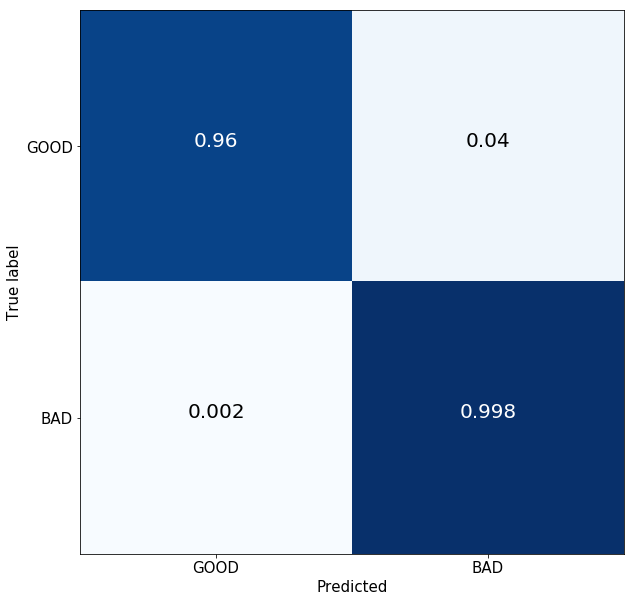

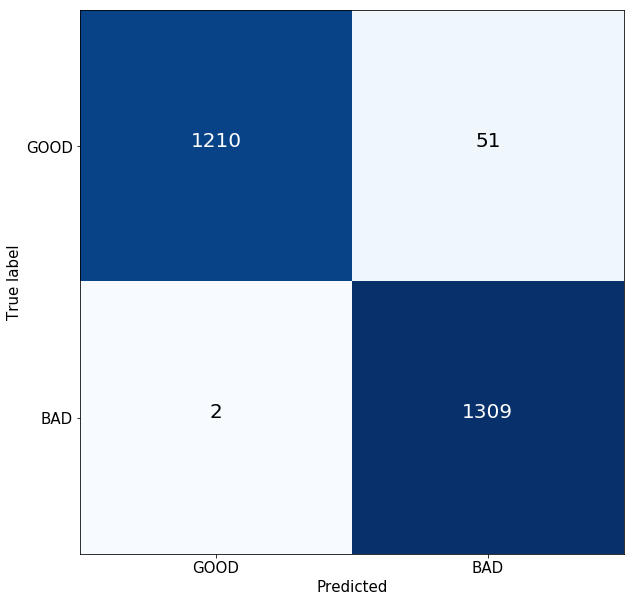

In [25]:
CMsave(AE_GB_test_Y, AE_pred, 'AE')

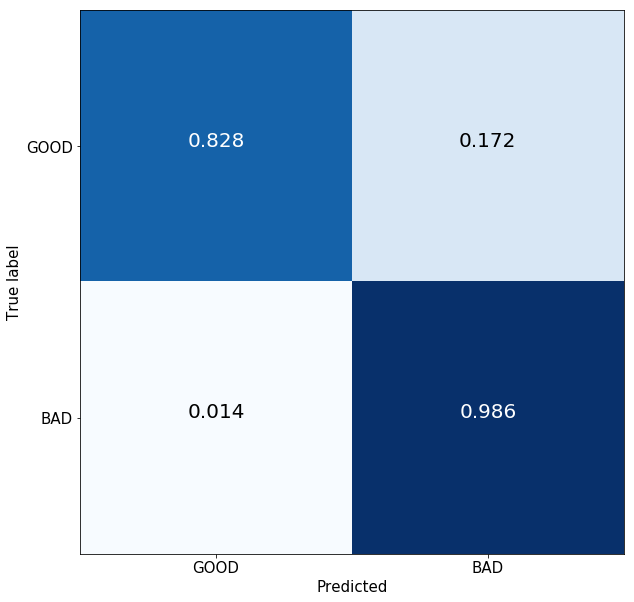

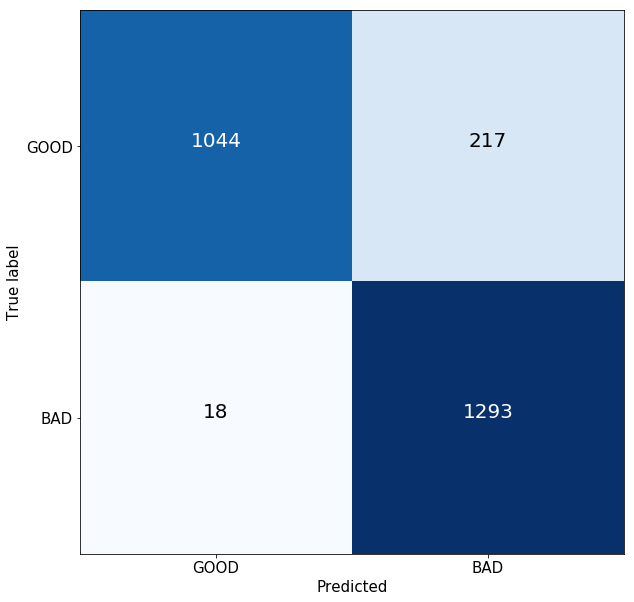

In [26]:
CMsave(Accel_GB_test_Y, Accel_pred, 'Accel')

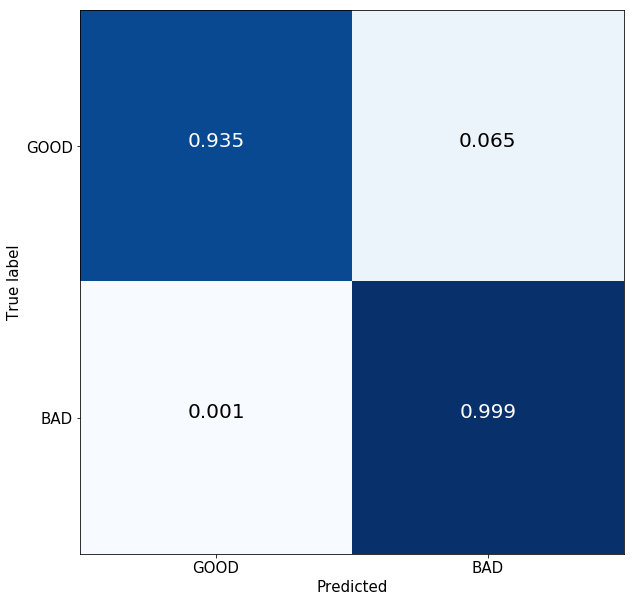

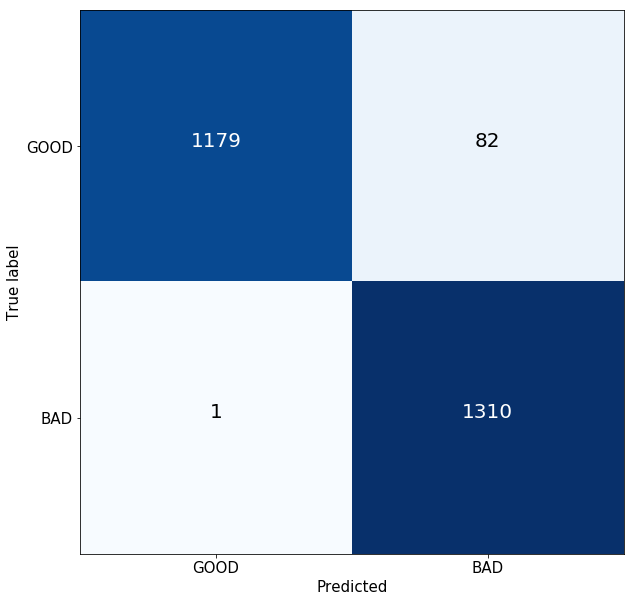

In [27]:
CMsave(A2_GB_test_Y, A2_pred, 'A2')